In [ ]:
!unzip credits.csv.zip

Archive:  credits.csv.zip
  inflating: credits.csv             


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score,accuracy_score
import pickle

import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data = pd.read_csv("movie_metadata.csv")
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [ ]:
data.shape

(5043, 28)

In [ ]:
 data.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

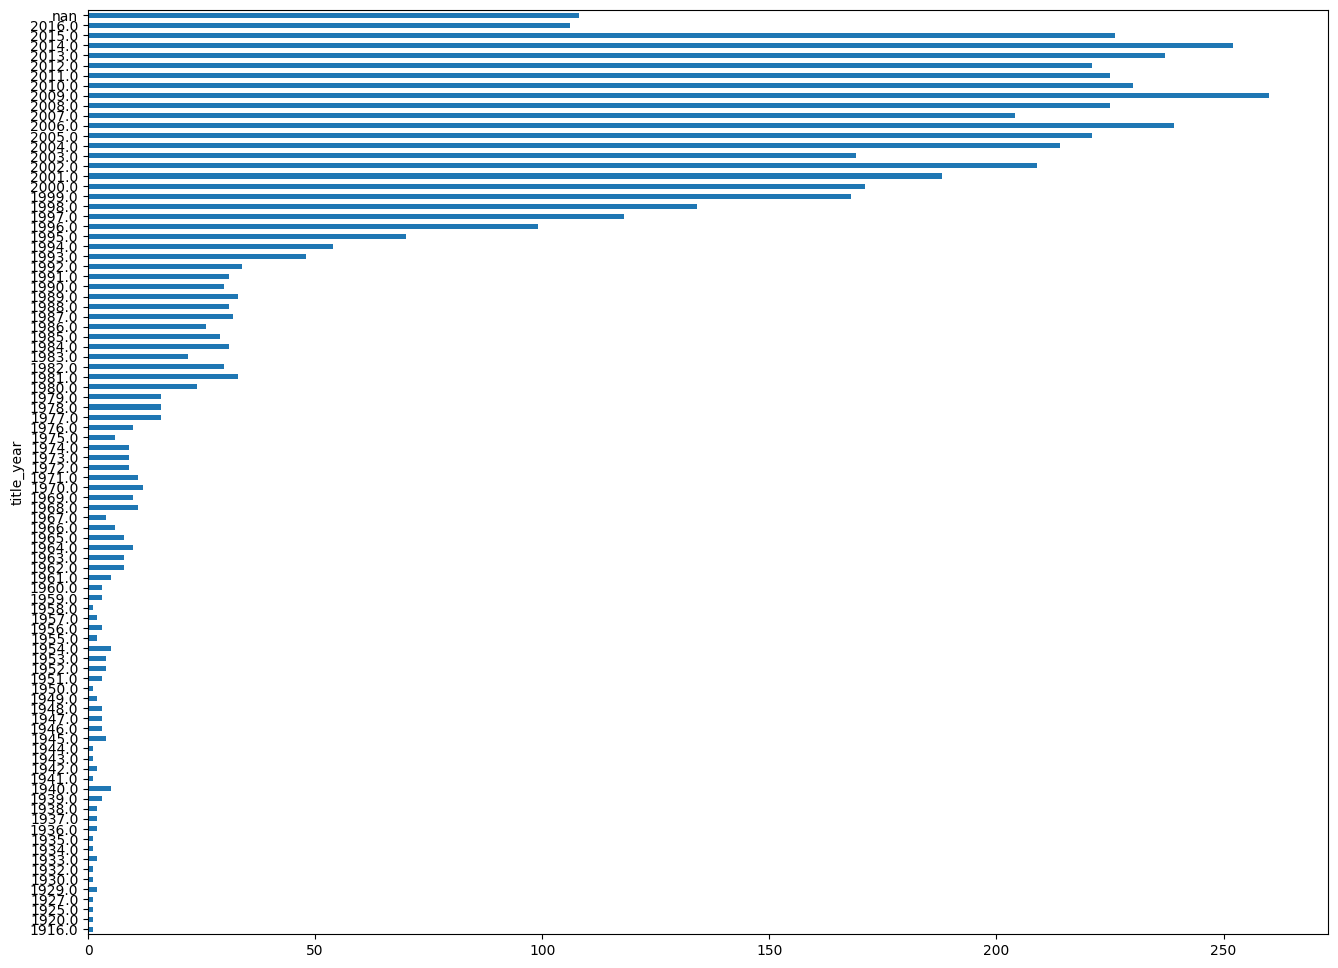

In [ ]:
data.title_year.value_counts(dropna=False).sort_index().plot(kind='barh', figsize=(16,12))
plt.show()

### Recommendations based on these features only

In [ ]:
data = data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'genres', 'movie_title']]
data.head()

,director_name,actor_1_name,actor_2_name,actor_3_name,genres,movie_title
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action|Adventure|Fantasy|Sci-Fi,Avatar
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action|Adventure|Thriller,Spectre
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action|Thriller,The Dark Knight Rises
4,Doug Walker,Doug Walker,Rob Walker,NaN,Documentary,Star Wars: Episode VII - The Force Awakens ...


In [ ]:
data.isnull().sum()

director_name    104
actor_1_name       7
actor_2_name      13
actor_3_name      23
genres             0
movie_title        0
dtype: int64

### Replacing NULL values with "Unknown"

In [ ]:
col = data.columns
for feature in col:
    data[feature] =  data[feature].replace(np.nan, "unknown")

In [ ]:
data.isnull().sum()

director_name    0
actor_1_name     0
actor_2_name     0
actor_3_name     0
genres           0
movie_title      0
dtype: int64

### Replacing Pipe("|") symbol in Genres feature

In [ ]:
data['genres'] = data['genres'].str.replace('|', ' ')

### Terminating Null char at end of movies titles

In [ ]:
data["movie_title"][1]

"Pirates of the Caribbean: At World's End\xa0"

In [ ]:
data["movie_title"][45]

'Furious 7\xa0'

In [ ]:
data["movie_title"] = data["movie_title"].apply(lambda x : x[:-1])

In [ ]:
data["movie_title"][1]

"Pirates of the Caribbean: At World's End"

In [ ]:
data["movie_title"][45]

'Furious 7'

In [ ]:
data.columns

Index(['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
       'genres', 'movie_title'],
      dtype='object')

In [ ]:
data.columns = ['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genres', 'movie_title']

In [ ]:
data["combined_data"] = data["actor1_name"] + " " + data["actor2_name"] + " " + data["actor3_name"] + " " + data["director_name"] + " " +  data["genres"]
data

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action Adventure Fantasy Sci-Fi,Avatar,CCH Pounder Joel David Moore Wes Studi James C...
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action Adventure Fantasy,Pirates of the Caribbean: At World's End,Johnny Depp Orlando Bloom Jack Davenport Gore ...
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action Adventure Thriller,Spectre,Christoph Waltz Rory Kinnear Stephanie Sigman ...
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action Thriller,The Dark Knight Rises,Tom Hardy Christian Bale Joseph Gordon-Levitt ...
4,Doug Walker,Doug Walker,Rob Walker,unknown,Documentary,Star Wars: Episode VII - The Force Awakens ...,Doug Walker Rob Walker unknown Doug Walker Doc...
...,...,...,...,...,...,...,...
5038,Scott Smith,Eric Mabius,Daphne Zuniga,Crystal Lowe,Comedy Drama,Signed Sealed Delivered,Eric Mabius Daphne Zuniga Crystal Lowe Scott S...
5039,unknown,Natalie Zea,Valorie Curry,Sam Underwood,Crime Drama Mystery Thriller,The Following,Natalie Zea Valorie Curry Sam Underwood unknow...
5040,Benjamin Roberds,Eva Boehnke,Maxwell Moody,David Chandler,Drama Horror Thriller,A Plague So Pleasant,Eva Boehnke Maxwell Moody David Chandler Benja...
5041,Daniel Hsia,Alan Ruck,Daniel Henney,Eliza Coupe,Comedy Drama Romance,Shanghai Calling,Alan Ruck Daniel Henney Eliza Coupe Daniel Hsi...


In [ ]:
data.to_csv("data.csv", index=False)

In [ ]:
credits = pd.read_csv("credits.csv")
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
meta_data = pd.read_csv("movies_metadata.csv")
meta_data.head()

<ipython-input-30-d626813b12b3>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_data = pd.read_csv("movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
meta_data['release_date'] = pd.to_datetime(meta_data['release_date'], errors="coerce")

Coerce -> invalid parse will be converted into Nan

In [ ]:
meta_data['year'] = meta_data['release_date'].dt.year

In [ ]:
meta_data['year'].value_counts().sort_index()

year
1874.0       1
1878.0       1
1883.0       1
1887.0       1
1888.0       2
          ... 
2015.0    1905
2016.0    1604
2017.0     532
2018.0       5
2020.0       1
Name: count, Length: 135, dtype: int64

In [ ]:
new_meta = meta_data.loc[meta_data.year == 2017, ['genres', 'id', 'title', 'year']]
new_meta

,genres,id,title,year
26560,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",166426,Pirates of the Caribbean: Dead Men Tell No Tales,2017.0
26561,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",141052,Justice League,2017.0
26565,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",284053,Thor: Ragnarok,2017.0
26566,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",283995,Guardians of the Galaxy Vol. 2,2017.0
30536,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",245842,The King's Daughter,2017.0
...,...,...,...,...
45398,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",468707,Thick Lashes of Lauri Mäntyvaara,2017.0
45417,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",461297,Cop and a Half: New Recruit,2017.0
45437,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",455661,In a Heartbeat,2017.0
45453,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",404604,Mom,2017.0


In [ ]:
new_meta["id"] = new_meta["id"].astype(int)

In [ ]:
data2 = pd.merge(new_meta, credits, on="id")

In [ ]:
data2["genres"] = data2["genres"].map(lambda x: ast.literal_eval(x))
data2["cast"] = data2["cast"].map(lambda x: ast.literal_eval(x))
data2["crew"] = data2["crew"].map(lambda x: ast.literal_eval(x))

In [ ]:
def make_genresList(genre):
    gen = []
    st = " "
    for i in genre:
        if i.get('name') == "Science Fiction":
            gen.append("Sci-Fi")
        else:
            gen.append(i.get('name'))
    if gen == []:
        return np.NaN
    else:
        return (st.join(gen))

In [ ]:
data2["genre_list"] = data2["genres"].map(lambda x: make_genresList(x))

In [ ]:
data2["genre_list"]

0      Adventure Action Fantasy Comedy
1      Action Adventure Fantasy Sci-Fi
2      Action Adventure Fantasy Sci-Fi
3       Action Adventure Comedy Sci-Fi
4             Fantasy Action Adventure
                    ...               
526                     Romance Comedy
527         Crime Comedy Action Family
528    Family Animation Romance Comedy
529               Crime Drama Thriller
530                                NaN
Name: genre_list, Length: 531, dtype: object

In [ ]:
def get_actor1(x):
    casts = []
    for i in x:
        casts.append(i.get('name'))
    if casts == []:
        return np.NaN
    else:
        return (casts[0])

In [ ]:
data2["actor1_name"] = data2["cast"].map(lambda x: get_actor1(x))

In [ ]:
data2["actor1_name"]

0               Johnny Depp
1               Ben Affleck
2           Chris Hemsworth
3               Chris Pratt
4            Pierce Brosnan
               ...         
526          Inka Haapamäki
527    Lou Diamond Phillips
528                     NaN
529          Sridevi Kapoor
530                     NaN
Name: actor1_name, Length: 531, dtype: object

In [ ]:
def get_actor2(x):
    casts = []
    for i in x:
        casts.append(i.get('name'))
    if casts == [] or len(casts) <= 1:
        return np.NaN
    else:
        return (casts[1])

In [ ]:
data2["actor2_name"] = data2["cast"].map(lambda x: get_actor2(x))

In [ ]:
data2["actor2_name"]

0       Javier Bardem
1        Henry Cavill
2      Tom Hiddleston
3         Zoe Saldana
4        William Hurt
            ...      
526     Rosa Honkonen
527     Wallace Shawn
528               NaN
529         Sajal Ali
530               NaN
Name: actor2_name, Length: 531, dtype: object

In [ ]:
def get_actor3(x):
    casts = []
    for i in x:
        casts.append(i.get('name'))
    if casts == [] or len(casts) <= 2:
        return np.NaN
    else:
        return (casts[2])

In [ ]:
data2["actor3_name"] = data2["cast"].map(lambda x: get_actor3(x))

In [ ]:
data2["actor3_name"]

0        Geoffrey Rush
1            Gal Gadot
2       Cate Blanchett
3        Dave Bautista
4      Benjamin Walker
            ...       
526     Tiitus Rantala
527        Gina Holden
528                NaN
529     Akshaye Khanna
530                NaN
Name: actor3_name, Length: 531, dtype: object

In [ ]:
def get_directors(x):
    dt = []
    st = " "
    for i in x:
        if i.get('job') == "Director":
            dt.append(i.get('name'))
    if dt == []:
        return np.NaN
    else:
        return (st.join(dt))

In [ ]:
data2["director_name"] = data2["crew"].map(lambda x: get_directors(x))
data2["director_name"]

0      Joachim Rønning Espen Sandberg
1                         Zack Snyder
2                       Taika Waititi
3                          James Gunn
4                       Sean McNamara
                    ...              
526                  Hannaleena Hauru
527             Jonathan A. Rosenbaum
528          Beth David Esteban Bravo
529                      Ravi Udyawar
530                     Daisy Asquith
Name: director_name, Length: 531, dtype: object

In [ ]:
movie_data = data2.loc[:, ['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genre_list', 'title']]
movie_data

,director_name,actor1_name,actor2_name,actor3_name,genre_list,title
0,Joachim Rønning Espen Sandberg,Johnny Depp,Javier Bardem,Geoffrey Rush,Adventure Action Fantasy Comedy,Pirates of the Caribbean: Dead Men Tell No Tales
1,Zack Snyder,Ben Affleck,Henry Cavill,Gal Gadot,Action Adventure Fantasy Sci-Fi,Justice League
2,Taika Waititi,Chris Hemsworth,Tom Hiddleston,Cate Blanchett,Action Adventure Fantasy Sci-Fi,Thor: Ragnarok
3,James Gunn,Chris Pratt,Zoe Saldana,Dave Bautista,Action Adventure Comedy Sci-Fi,Guardians of the Galaxy Vol. 2
4,Sean McNamara,Pierce Brosnan,William Hurt,Benjamin Walker,Fantasy Action Adventure,The King's Daughter
...,...,...,...,...,...,...
526,Hannaleena Hauru,Inka Haapamäki,Rosa Honkonen,Tiitus Rantala,Romance Comedy,Thick Lashes of Lauri Mäntyvaara
527,Jonathan A. Rosenbaum,Lou Diamond Phillips,Wallace Shawn,Gina Holden,Crime Comedy Action Family,Cop and a Half: New Recruit
528,Beth David Esteban Bravo,NaN,NaN,NaN,Family Animation Romance Comedy,In a Heartbeat
529,Ravi Udyawar,Sridevi Kapoor,Sajal Ali,Akshaye Khanna,Crime Drama Thriller,Mom


In [ ]:
movie_data.isnull().sum()

director_name     4
actor1_name      22
actor2_name      55
actor3_name      70
genre_list        7
title             0
dtype: int64

In [ ]:
movie_data = movie_data.dropna(how="any")
movie_data.isnull().sum()

director_name    0
actor1_name      0
actor2_name      0
actor3_name      0
genre_list       0
title            0
dtype: int64

In [ ]:
movie_data = movie_data.rename(columns = {'genre_list' : 'genres'})
movie_data = movie_data.rename(columns = {'title' : 'movie_title'})

In [ ]:
movie_data['movie_title'] = movie_data['movie_title'].str.lower()

In [ ]:
movie_data.columns

Index(['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genres',
       'movie_title'],
      dtype='object')

In [ ]:
movie_data["combined_data"] = movie_data["actor1_name"] + " " + movie_data["actor2_name"] + " " + movie_data["actor3_name"] + " " + movie_data["director_name"] + " " +  movie_data["genres"]
movie_data

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,Joachim Rønning Espen Sandberg,Johnny Depp,Javier Bardem,Geoffrey Rush,Adventure Action Fantasy Comedy,pirates of the caribbean: dead men tell no tales,Johnny Depp Javier Bardem Geoffrey Rush Joachi...
1,Zack Snyder,Ben Affleck,Henry Cavill,Gal Gadot,Action Adventure Fantasy Sci-Fi,justice league,Ben Affleck Henry Cavill Gal Gadot Zack Snyder...
2,Taika Waititi,Chris Hemsworth,Tom Hiddleston,Cate Blanchett,Action Adventure Fantasy Sci-Fi,thor: ragnarok,Chris Hemsworth Tom Hiddleston Cate Blanchett ...
3,James Gunn,Chris Pratt,Zoe Saldana,Dave Bautista,Action Adventure Comedy Sci-Fi,guardians of the galaxy vol. 2,Chris Pratt Zoe Saldana Dave Bautista James Gu...
4,Sean McNamara,Pierce Brosnan,William Hurt,Benjamin Walker,Fantasy Action Adventure,the king's daughter,Pierce Brosnan William Hurt Benjamin Walker Se...
...,...,...,...,...,...,...,...
524,Jim Strouse,Jessica Williams,Chris O'Dowd,Keith Stanfield,Romance Comedy,the incredible jessica james,Jessica Williams Chris O'Dowd Keith Stanfield ...
525,Farhad Mann,Adelaide Kane,Benjamin Hollingsworth,Jean Louisa Kelly,Romance,can't buy my love,Adelaide Kane Benjamin Hollingsworth Jean Loui...
526,Hannaleena Hauru,Inka Haapamäki,Rosa Honkonen,Tiitus Rantala,Romance Comedy,thick lashes of lauri mäntyvaara,Inka Haapamäki Rosa Honkonen Tiitus Rantala Ha...
527,Jonathan A. Rosenbaum,Lou Diamond Phillips,Wallace Shawn,Gina Holden,Crime Comedy Action Family,cop and a half: new recruit,Lou Diamond Phillips Wallace Shawn Gina Holden...


In [ ]:
data

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action Adventure Fantasy Sci-Fi,Avatar,CCH Pounder Joel David Moore Wes Studi James C...
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action Adventure Fantasy,Pirates of the Caribbean: At World's End,Johnny Depp Orlando Bloom Jack Davenport Gore ...
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action Adventure Thriller,Spectre,Christoph Waltz Rory Kinnear Stephanie Sigman ...
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action Thriller,The Dark Knight Rises,Tom Hardy Christian Bale Joseph Gordon-Levitt ...
4,Doug Walker,Doug Walker,Rob Walker,unknown,Documentary,Star Wars: Episode VII - The Force Awakens ...,Doug Walker Rob Walker unknown Doug Walker Doc...
...,...,...,...,...,...,...,...
5038,Scott Smith,Eric Mabius,Daphne Zuniga,Crystal Lowe,Comedy Drama,Signed Sealed Delivered,Eric Mabius Daphne Zuniga Crystal Lowe Scott S...
5039,unknown,Natalie Zea,Valorie Curry,Sam Underwood,Crime Drama Mystery Thriller,The Following,Natalie Zea Valorie Curry Sam Underwood unknow...
5040,Benjamin Roberds,Eva Boehnke,Maxwell Moody,David Chandler,Drama Horror Thriller,A Plague So Pleasant,Eva Boehnke Maxwell Moody David Chandler Benja...
5041,Daniel Hsia,Alan Ruck,Daniel Henney,Eliza Coupe,Comedy Drama Romance,Shanghai Calling,Alan Ruck Daniel Henney Eliza Coupe Daniel Hsi...


In [ ]:
new_data = pd.concat([data, movie_data])
new_data.head()

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action Adventure Fantasy Sci-Fi,Avatar,CCH Pounder Joel David Moore Wes Studi James C...
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action Adventure Fantasy,Pirates of the Caribbean: At World's End,Johnny Depp Orlando Bloom Jack Davenport Gore ...
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action Adventure Thriller,Spectre,Christoph Waltz Rory Kinnear Stephanie Sigman ...
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action Thriller,The Dark Knight Rises,Tom Hardy Christian Bale Joseph Gordon-Levitt ...
4,Doug Walker,Doug Walker,Rob Walker,unknown,Documentary,Star Wars: Episode VII - The Force Awakens ...,Doug Walker Rob Walker unknown Doug Walker Doc...


In [ ]:
new_data.shape

(5501, 7)

In [ ]:
new_data.drop_duplicates(subset="movie_title", keep='last', inplace=True)
new_data

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action Adventure Fantasy Sci-Fi,Avatar,CCH Pounder Joel David Moore Wes Studi James C...
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action Adventure Fantasy,Pirates of the Caribbean: At World's End,Johnny Depp Orlando Bloom Jack Davenport Gore ...
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action Adventure Thriller,Spectre,Christoph Waltz Rory Kinnear Stephanie Sigman ...
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action Thriller,The Dark Knight Rises,Tom Hardy Christian Bale Joseph Gordon-Levitt ...
4,Doug Walker,Doug Walker,Rob Walker,unknown,Documentary,Star Wars: Episode VII - The Force Awakens ...,Doug Walker Rob Walker unknown Doug Walker Doc...
...,...,...,...,...,...,...,...
524,Jim Strouse,Jessica Williams,Chris O'Dowd,Keith Stanfield,Romance Comedy,the incredible jessica james,Jessica Williams Chris O'Dowd Keith Stanfield ...
525,Farhad Mann,Adelaide Kane,Benjamin Hollingsworth,Jean Louisa Kelly,Romance,can't buy my love,Adelaide Kane Benjamin Hollingsworth Jean Loui...
526,Hannaleena Hauru,Inka Haapamäki,Rosa Honkonen,Tiitus Rantala,Romance Comedy,thick lashes of lauri mäntyvaara,Inka Haapamäki Rosa Honkonen Tiitus Rantala Ha...
527,Jonathan A. Rosenbaum,Lou Diamond Phillips,Wallace Shawn,Gina Holden,Crime Comedy Action Family,cop and a half: new recruit,Lou Diamond Phillips Wallace Shawn Gina Holden...


In [ ]:
new_data.to_csv("new_data.csv", index=False)

### Extracting features of 2018 movies from wikipedia

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2018"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]

In [ ]:
df12 = pd.concat([df1,df2], ignore_index=True)
df34 = pd.concat([df3,df4], ignore_index=True)
df_2018 = pd.concat([df12,df34], ignore_index=True)

In [ ]:
df_2018

,Opening,Opening.1,Title,Production company,Cast and crew,.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Ref.,Ref.
0,J A N U A R Y,5,Insidious: The Last Key,Universal Pictures / Blumhouse Productions / S...,Adam Robitel (director); Leigh Whannell (scree...,[2],NaN
1,J A N U A R Y,5,The Strange Ones,Vertical Entertainment,Christopher Radcliff (director/screenplay); La...,[3],NaN
2,J A N U A R Y,12,The Commuter,Lionsgate / StudioCanal / The Picture Company,Jaume Collet-Serra (director); Byron Willinger...,[4],NaN
3,J A N U A R Y,12,Proud Mary,Screen Gems,"Babak Najafi (director); John S. Newman, Chris...",[5],NaN
4,J A N U A R Y,12,Acts of Violence,Lionsgate Premiere,Brett Donowho (director); Nicolas Aaron Mezzan...,[6],NaN
...,...,...,...,...,...,...,...
242,D E C E M B E R,21,Second Act,STX Entertainment,"Peter Segal (director); Justin Zackham, Elaine...",NaN,[236]
243,D E C E M B E R,25,Holmes & Watson,Columbia Pictures / Gary Sanchez Productions /...,Etan Cohen (director/screenplay); Will Ferrell...,NaN,[142]
244,D E C E M B E R,25,Vice,Annapurna Pictures / Plan B Entertainment,Adam McKay (director/screenplay); Christian Ba...,NaN,[117]
245,D E C E M B E R,25,On the Basis of Sex,Focus Features,Mimi Leder (director); Daniel Stiepleman (scre...,NaN,[207]


### to get a genres of these movies using api

In [ ]:
!pip install tmdbv3api

In [ ]:
from tmdbv3api import TMDb
import json
import requests
tmdb = TMDb()
tmdb.api_key = 'aae35bb54e615d32a61a94acd9d45ef8'

In [ ]:
from tmdbv3api import TMDb, Movie
import requests
import numpy as np

tmdb = TMDb()
tmdb.api_key = 'aae35bb54e615d32a61a94acd9d45ef8'
tmdb_movie = Movie()

def get_genre(x):
    genres = []

    try:
        result = tmdb_movie.search(x)
        if not result:
            print(f"No results found for {x}")
            return np.NaN

        movie_id = result[0].id
        response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={tmdb.api_key}')

        if response.status_code != 200:
            print(f"Failed to fetch data for movie ID {movie_id}: {response.status_code}")
            return np.NaN

        data_json = response.json()

        if 'genres' in data_json and data_json['genres']:
            genres = [genre['name'] for genre in data_json['genres']]
            return " ".join(genres)
        else:
            print(f"No genres found for movie ID {movie_id}")
            return np.NaN

    except Exception as e:
        print(f"An error occurred: {e}")
        return np.NaN


In [ ]:
df_2018['genres'] = df_2018['Title'].map(lambda x:get_genre(str(x)))

In [ ]:
df_2018 = df_2018[['Title', 'Cast and crew', 'genres']]

In [ ]:
def get_director(x):
    if " (director/screenplay); " in x:
        return x.split(" (director/screenplay); ")[0]
    elif " (director/acreenplay);" in x:
      return x.split(" (director/acreenplay); ")[0]
    elif " (director)" in x:
        return x.split(" (director)")[0]
    elif " (directors)" in x:
        return x.split(" (directors)")[0]


In [ ]:
df_2018['director_name'] = df_2018['Cast and crew'].map(lambda x: get_director(x))

<ipython-input-76-4838efec492a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['director_name'] = df_2018['Cast and crew'].map(lambda x: get_director(x))


In [ ]:
def get_actor1(x):
    # if "(screenplay);" in x:
    #     return ((x.split("(screenplay);")[-1]).split("; ")[0]).strip()
    # elif "(director/screenplay)" in x:
    #     return ((x.split("(director/screenplay)")[-1]).split("; ")[0]).strip()
    # return np.NaN
    ans = np.NaN
    if "screenplay); " in x:
      ans = ((x.split("screenplay); ")[-1]).split(", ")[0])
      if " (director);" in ans:
        s = x.split(" (director); ")[1]
        return s.split(", ")[0]
      else:
        return ans
    elif "acreenplay); " in x:
      return ((x.split("acreenplay); ")[-1]).split(", ")[0])
    else:
      return np.NaN

In [ ]:
df_2018['actor1_name'] = df_2018['Cast and crew'].map(lambda x: get_actor1(x))

<ipython-input-78-b047fad93bb4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['actor1_name'] = df_2018['Cast and crew'].map(lambda x: get_actor1(x))


In [ ]:
def get_actor2(x):
    if len((x.split("screenplay); ")[-1]).split(", ")) < 2:
        return np.NaN
    else:
        return ((x.split("screenplay); ")[-1]).split(", ")[1])

In [ ]:
df_2018['actor2_name'] = df_2018['Cast and crew'].map(lambda x: get_actor2(x))

<ipython-input-80-049d1eb99b6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['actor2_name'] = df_2018['Cast and crew'].map(lambda x: get_actor2(x))


In [ ]:
def get_actor3(x):
    if len((x.split("screenplay); ")[-1]).split(", ")) < 3:
        return np.NaN
    else:
        return ((x.split("screenplay); ")[-1]).split(", ")[2])

In [ ]:
df_2018['actor3_name'] = df_2018['Cast and crew'].map(lambda x: get_actor3(x))

<ipython-input-82-c9374c03508f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['actor3_name'] = df_2018['Cast and crew'].map(lambda x: get_actor3(x))


In [ ]:
df_2018 = df_2018.rename(columns={'Title':'movie_title'})

In [ ]:
new_df18 = df_2018.loc[:,['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genres', 'movie_title']]

In [ ]:
new_df18['actor2_name'] = new_df18['actor1_name'].replace(np.nan, 'unknown')
new_df18['actor3_name'] = new_df18['actor3_name'].replace(np.nan, 'unknown')

In [ ]:
new_df18['movie_title'] = new_df18['movie_title'].str.lower()

In [ ]:
new_df18['combined_data'] = new_df18['actor1_name'] + ' ' + new_df18['actor2_name'] + ' '+ new_df18['actor3_name'] + ' '+ new_df18['director_name'] +' ' + new_df18['genres']

In [ ]:
new_df18.head()

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,Adam Robitel,Lin Shaye,Lin Shaye,Leigh Whannell,Horror Mystery Thriller,insidious: the last key,Lin Shaye Lin Shaye Leigh Whannell Adam Robite...
1,Christopher Radcliff,Alex Pettyfer,Alex Pettyfer,Emily Althaus,Drama Mystery,the strange ones,Alex Pettyfer Alex Pettyfer Emily Althaus Chri...
2,Jaume Collet-Serra,Liam Neeson,Liam Neeson,Patrick Wilson,Action Thriller Mystery,the commuter,Liam Neeson Liam Neeson Patrick Wilson Jaume C...
3,Babak Najafi,Taraji P. Henson,Taraji P. Henson,Billy Brown,Thriller Action Crime,proud mary,Taraji P. Henson Taraji P. Henson Billy Brown ...
4,Brett Donowho,Bruce Willis,Bruce Willis,Shawn Ashmore,Action Crime Thriller,acts of violence,Bruce Willis Bruce Willis Shawn Ashmore Brett ...


### Extracting features of 2019 movies from Wikipedia

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2019"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]

In [ ]:
df12 = pd.concat([df1,df2], ignore_index=True)
df34 = pd.concat([df3,df4], ignore_index=True)
df_2019 = pd.concat([df12,df34], ignore_index=True)

In [ ]:
df_2019

,Opening,Opening.1,Title,Production company,Cast and crew,Ref.
0,J A N U A R Y,4,Escape Room,Columbia Pictures / Original Film,"Adam Robitel (director); Bragi F. Schut, Maria...",[2]
1,J A N U A R Y,4,Rust Creek,IFC Films / Lunacy Productions,Jen McGowan (director); Julie Lipson (screenpl...,[3]
2,J A N U A R Y,4,American Hangman,Hangman Justice Productions,Wilson Coneybeare (director/screenplay); Donal...,[4]
3,J A N U A R Y,11,A Dog's Way Home,Columbia Pictures,Charles Martin Smith (director); W. Bruce Came...,[5]
4,J A N U A R Y,11,The Upside,STX Entertainment,Neil Burger (director); Jon Hartmere (screenpl...,[6]
...,...,...,...,...,...,...
242,D E C E M B E R,25,Spies in Disguise,20th Century Fox / Blue Sky Studios / Chernin ...,"Nick Bruno, Troy Quane (directors); Brad Copel...",[130]
243,D E C E M B E R,25,Little Women,Columbia Pictures / Regency Enterprises,Greta Gerwig (director/screenplay); Saoirse Ro...,[223]
244,D E C E M B E R,25,1917,Universal Pictures / DreamWorks Pictures,Sam Mendes (director/screenplay); Krysty Wilso...,[224]
245,D E C E M B E R,25,Just Mercy,Warner Bros. Pictures / Participant Media,"Destin Daniel Cretton (director/screenplay), A...",[225]


In [ ]:
df_2019['genres'] = df_2019['Title'].map(lambda x:get_genre(str(x)))

In [ ]:
df_2019 = df_2019[['Title', 'Cast and crew', 'genres']]

In [ ]:
df_2019['director_name'] = df_2019['Cast and crew'].map(lambda x: get_director(x))

<ipython-input-94-84d0c3ababbd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['director_name'] = df_2019['Cast and crew'].map(lambda x: get_director(x))


In [ ]:
df_2019['actor1_name'] = df_2019['Cast and crew'].map(lambda x: get_actor1(x))

<ipython-input-95-5b5ed384a42e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['actor1_name'] = df_2019['Cast and crew'].map(lambda x: get_actor1(x))


In [ ]:
df_2019['actor2_name'] = df_2019['Cast and crew'].map(lambda x: get_actor2(x))

<ipython-input-96-99ebf23e73ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['actor2_name'] = df_2019['Cast and crew'].map(lambda x: get_actor2(x))


In [ ]:
df_2019['actor3_name'] = df_2019['Cast and crew'].map(lambda x: get_actor3(x))

In [ ]:
df_2019 = df_2019.rename(columns={'Title':'movie_title'})

In [ ]:
new_df19 = df_2019.loc[:,['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genres', 'movie_title']]

In [ ]:
new_df19['actor2_name'] = new_df19['actor2_name'].replace(np.nan, 'unknown')
new_df19['actor3_name'] = new_df19['actor3_name'].replace(np.nan, 'unknown')

In [ ]:
new_df19['movie_title'] = new_df19['movie_title'].str.lower()

In [ ]:
new_df19['combined_data'] = new_df19['actor1_name'] + ' ' + new_df19['actor2_name'] + ' '+ new_df19['actor3_name'] + ' '+ new_df19['director_name'] +' ' + new_df19['genres']

In [ ]:
new_df19.head()

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,Adam Robitel,Taylor Russell,Logan Miller,Deborah Ann Woll,Horror Thriller Mystery,escape room,Taylor Russell Logan Miller Deborah Ann Woll A...
1,Jen McGowan,Hermione Corfield,Jay Paulson,Sean O'Bryan,Thriller Drama Action Crime,rust creek,Hermione Corfield Jay Paulson Sean O'Bryan Jen...
2,Wilson Coneybeare,Donald Sutherland,Vincent Kartheiser,Oliver Dennis,Thriller,american hangman,Donald Sutherland Vincent Kartheiser Oliver De...
3,Charles Martin Smith,Bryce Dallas Howard,Edward James Olmos,Alexandra Shipp,Drama Adventure Family,a dog's way home,Bryce Dallas Howard Edward James Olmos Alexand...
4,Neil Burger,Bryan Cranston,Kevin Hart,Nicole Kidman,Comedy Drama,the upside,Bryan Cranston Kevin Hart Nicole Kidman Neil B...


### Extracting features of 2020 movies from Wikipedia

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2020"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]

In [ ]:
df12 = pd.concat([df1,df2], ignore_index=True)
df34 = pd.concat([df3,df4], ignore_index=True)
df_2020 = pd.concat([df12,df34], ignore_index=True)

In [ ]:
df_2020

,Opening,Opening.1,Title,Production company,Cast and crew,.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Ref.,Ref.
0,J A N U A R Y,3,The Grudge,Screen Gems / Stage 6 Films / Ghost House Pict...,Nicolas Pesce (director/screenplay); Andrea Ri...,[2],NaN
1,J A N U A R Y,10,Underwater,20th Century Fox / TSG Entertainment / Chernin...,"William Eubank (director); Brian Duffield, Ada...",[3],NaN
2,J A N U A R Y,10,Like a Boss,Paramount Pictures / Artists First,"Miguel Arteta (director); Sam Pitman, Adam Col...",[4],NaN
3,J A N U A R Y,10,Three Christs,IFC Films,Jon Avnet (director/screenplay); Eric Nazarian...,NaN,NaN
4,J A N U A R Y,10,Inherit the Viper,Lionsgate / Barry Films / Tycor International ...,Anthony Jerjen (director); Andrew Crabtree (sc...,[5],NaN
...,...,...,...,...,...,...,...
270,D E C E M B E R,25,We Can Be Heroes,Netflix / Troublemaker Studios / Double R Prod...,Robert Rodriguez (director/screenplay); Priyan...,NaN,[243]
271,D E C E M B E R,25,News of the World,Universal Pictures / Perfect World Pictures,Paul Greengrass (director/screenplay); Luke Da...,NaN,[244]
272,D E C E M B E R,25,One Night in Miami...,Amazon Studios,Regina King (director); Kemp Powers (screenpla...,NaN,[245]
273,D E C E M B E R,25,Promising Young Woman,Focus Features / FilmNation Entertainment,Emerald Fennell (director/screenplay); Carey M...,NaN,[246]


In [ ]:
df_2020['genres'] = df_2020['Title'].map(lambda x:get_genre(str(x)))

An error occurred: getattr(): attribute name must be string
An error occurred: getattr(): attribute name must be string


In [ ]:
df_2020 = df_2020[['Title', 'Cast and crew', 'genres']]

In [ ]:
df_2020['director_name'] = df_2020['Cast and crew'].map(lambda x: get_director(str(x)))

<ipython-input-109-bc52fe9b0c35>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['director_name'] = df_2020['Cast and crew'].map(lambda x: get_director(str(x)))


In [ ]:
df_2020['actor1_name'] = df_2020['Cast and crew'].map(lambda x: get_actor1(str(x)))

<ipython-input-110-b6fae771f54d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['actor1_name'] = df_2020['Cast and crew'].map(lambda x: get_actor1(str(x)))


In [ ]:
df_2020['actor2_name'] = df_2020['Cast and crew'].map(lambda x: get_actor2(str(x)))

<ipython-input-111-651aa652b558>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['actor2_name'] = df_2020['Cast and crew'].map(lambda x: get_actor2(str(x)))


In [ ]:
df_2020['actor3_name'] = df_2020['Cast and crew'].map(lambda x: get_actor3(str(x)))

<ipython-input-112-79c3b71bf3ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['actor3_name'] = df_2020['Cast and crew'].map(lambda x: get_actor3(str(x)))


In [ ]:
df_2020 = df_2020.rename(columns={'Title':'movie_title'})

In [ ]:
new_df20 = df_2020.loc[:,['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genres', 'movie_title']]

In [ ]:
new_df20['actor2_name'] = new_df20['actor2_name'].replace(np.nan, 'unknown')
new_df20['actor3_name'] = new_df20['actor3_name'].replace(np.nan, 'unknown')

In [ ]:
new_df20['movie_title'] = new_df20['movie_title'].str.lower()

In [ ]:
new_df20['combined_data'] = new_df20['actor1_name'] + ' ' + new_df20['actor2_name'] + ' '+ new_df20['actor3_name'] + ' '+ new_df20['director_name'] +' ' + new_df20['genres']

In [ ]:
new_df20.head()

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,Nicolas Pesce,Andrea Riseborough,Demián Bichir,John Cho,Horror Mystery,the grudge,Andrea Riseborough Demián Bichir John Cho Nico...
1,William Eubank,Kristen Stewart,Vincent Cassel,Jessica Henwick,Horror Science Fiction Action Adventure,underwater,Kristen Stewart Vincent Cassel Jessica Henwick...
2,Miguel Arteta,Tiffany Haddish,Rose Byrne,Salma Hayek,Comedy,like a boss,Tiffany Haddish Rose Byrne Salma Hayek Miguel ...
3,Jon Avnet,Richard Gere,Peter Dinklage,Walton Goggins,Drama,three christs,Richard Gere Peter Dinklage Walton Goggins Jon...
4,Anthony Jerjen,Josh Hartnett,Margarita Levieva,Chandler Riggs,Crime Thriller Drama,inherit the viper,Josh Hartnett Margarita Levieva Chandler Riggs...


### Extracting features of 2021 movies from Wikipedia

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2021"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]

In [ ]:
df12 = pd.concat([df1,df2], ignore_index=True)
df34 = pd.concat([df3,df4], ignore_index=True)
df_2021 = pd.concat([df12,df34], ignore_index=True)

In [ ]:
df_2021

,Opening,Opening.1,Title,Production company,Cast and crew,.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Ref.,Ref.
0,J A N U A R Y,1.0,Shadow in the Cloud,Vertical Entertainment,Roseanne Liang (director/screenplay); Max Land...,[2],NaN
1,J A N U A R Y,5.0,Hacksaw,Leone Films / Midnight Releasing,"Anthony Leone (director/screenplay); Amy Cay, ...",[3],NaN
2,J A N U A R Y,12.0,Dr. Bird's Advice for Sad Poets,Relativity Media / Ketchup Entertainment,Yaniv Raz (director/screenplay); Lucas Jade Zu...,[4],NaN
3,J A N U A R Y,13.0,The White Tiger,Netflix / ARRAY / Purple Pebble Pictures,Ramin Bahrani (director/screenplay); Adarsh Go...,NaN,NaN
4,J A N U A R Y,14.0,Locked Down,HBO Max / Warner Bros. Pictures,Doug Liman (director); Steven Knight (screenpl...,[5],NaN
...,...,...,...,...,...,...,...
360,D E C E M B E R,25.0,The Tragedy of Macbeth,Apple TV+ / A24 / IAC Films,Joel Coen (director/screenplay); Denzel Washin...,NaN,[277]
361,D E C E M B E R,25.0,A Journal for Jordan,Columbia Pictures / Escape Artists / Bron Studios,Denzel Washington (director); Virgil Williams ...,NaN,[278]
362,D E C E M B E R,25.0,American Underdog,Lionsgate,"Erwin brothers (directors); Jon Erwin, David A...",NaN,[279]
363,D E C E M B E R,26.0,Memoria,Neon,Apichatpong Weerasethakul (director/acreenplay...,NaN,[280]


In [ ]:
df_2021['genres'] = df_2021['Title'].map(lambda x:get_genre(str(x)))

An error occurred: getattr(): attribute name must be string


In [ ]:
df_2021 = df_2021[['Title', 'Cast and crew', 'genres']]

In [ ]:
df_2021['director_name'] = df_2021['Cast and crew'].map(lambda x: get_director(str(x)))

<ipython-input-124-059d9cfe3ca6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['director_name'] = df_2021['Cast and crew'].map(lambda x: get_director(str(x)))


In [ ]:
df_2021['actor1_name'] = df_2021['Cast and crew'].map(lambda x: get_actor1(str(x)))

<ipython-input-125-79b794bfe852>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['actor1_name'] = df_2021['Cast and crew'].map(lambda x: get_actor1(str(x)))


In [ ]:
df_2021['actor2_name'] = df_2021['Cast and crew'].map(lambda x: get_actor2(str(x)))

<ipython-input-126-4fd9ad81bd2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['actor2_name'] = df_2021['Cast and crew'].map(lambda x: get_actor2(str(x)))


In [ ]:
df_2021['actor3_name'] = df_2021['Cast and crew'].map(lambda x: get_actor3(str(x)))

<ipython-input-127-6aaf650570df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['actor3_name'] = df_2021['Cast and crew'].map(lambda x: get_actor3(str(x)))


In [ ]:
df_2021 = df_2021.rename(columns={'Title':'movie_title'})

In [ ]:
new_df21 = df_2021.loc[:,['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genres', 'movie_title']]

In [ ]:
new_df21['actor2_name'] = new_df21['actor2_name'].replace(np.nan, 'unknown')
new_df21['actor3_name'] = new_df21['actor3_name'].replace(np.nan, 'unknown')

In [ ]:
new_df21['movie_title'] = new_df21['movie_title'].str.lower()

In [ ]:
new_df21['combined_data'] = new_df21['actor1_name'] + ' ' + new_df21['actor2_name'] + ' '+ new_df21['actor3_name'] + ' '+ new_df21['director_name'] +' ' + new_df21['genres']

In [ ]:
new_df21.head()

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,Roseanne Liang,Chloë Grace Moretz,Taylor John Smith,Beulah Koale,Horror Action War,shadow in the cloud,Chloë Grace Moretz Taylor John Smith Beulah Ko...
1,Anthony Leone,Amy Cay,Brian Patrick Butler,Michael C. Burgess,Adventure Family TV Movie Western,hacksaw,Amy Cay Brian Patrick Butler Michael C. Burges...
2,Yaniv Raz,Lucas Jade Zumann,Taylor Russell,Chase Stokes,Comedy Drama,dr. bird's advice for sad poets,Lucas Jade Zumann Taylor Russell Chase Stokes ...
3,Ramin Bahrani,Adarsh Gourav,Rajkummar Rao,Priyanka Chopra Jonas,Drama,the white tiger,Adarsh Gourav Rajkummar Rao Priyanka Chopra Jo...
4,Doug Liman,Anne Hathaway,Chiwetel Ejiofor,Stephen Merchant,Comedy Crime Romance,locked down,Anne Hathaway Chiwetel Ejiofor Stephen Merchan...


### Extracting features of 2022 movies from Wikipedia

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2022"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]

In [ ]:
df12 = pd.concat([df1,df2], ignore_index=True)
df34 = pd.concat([df3,df4], ignore_index=True)
df_2022 = pd.concat([df12,df34], ignore_index=True)

In [ ]:
df_2022

,Opening,Opening.1,Title,Production company,Cast and crew,.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Ref.,Ref.
0,J A N U A R Y,7.0,The 355,Universal Pictures / Freckle Films / FilmNatio...,Simon Kinberg (director/screenplay); Theresa R...,[2],NaN
1,J A N U A R Y,7.0,The Legend of La Llorona,Saban Films / Ageless Pictures,Patricia Harris Seeley (director); José Prende...,[3],NaN
2,J A N U A R Y,7.0,The Commando,Saban Films / Premiere Entertainment,Asif Akbar (director); Koji Steven Sakai (scre...,[4],NaN
3,J A N U A R Y,7.0,American Siege,Vertical Entertainment,Edward John Drake (director/screenplay); Timot...,[5],NaN
4,J A N U A R Y,14.0,Scream,Paramount Pictures / Spyglass Media Group / Ra...,"Matt Bettinelli-Olpin, Tyler Gillett (director...",[6],NaN
...,...,...,...,...,...,...,...
312,D E C E M B E R,30.0,"Alice, Darling",Lionsgate / Elevation Pictures,Mary Nighy (director); Alanna Francis (screenp...,NaN,[261]
313,D E C E M B E R,NaN,NaN,NaN,NaN,NaN,NaN
314,D E C E M B E R,NaN,NaN,NaN,NaN,NaN,NaN
315,D E C E M B E R,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_2022['genres'] = df_2022['Title'].map(lambda x:get_genre(str(x)))

An error occurred: getattr(): attribute name must be string


In [ ]:
df_2022 = df_2022[['Title', 'Cast and crew', 'genres']]

In [ ]:
df_2022['director_name'] = df_2022['Cast and crew'].map(lambda x: get_director(str(x)))

<ipython-input-139-bde37e357dd2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['director_name'] = df_2022['Cast and crew'].map(lambda x: get_director(str(x)))


In [ ]:
df_2022['actor1_name'] = df_2022['Cast and crew'].map(lambda x: get_actor1(str(x)))

<ipython-input-140-55860a40ced3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['actor1_name'] = df_2022['Cast and crew'].map(lambda x: get_actor1(str(x)))


In [ ]:
df_2022['actor2_name'] = df_2022['Cast and crew'].map(lambda x: get_actor2(str(x)))

<ipython-input-141-7eed836da268>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['actor2_name'] = df_2022['Cast and crew'].map(lambda x: get_actor2(str(x)))


In [ ]:
df_2022['actor3_name'] = df_2022['Cast and crew'].map(lambda x: get_actor3(str(x)))

<ipython-input-142-03d06401f725>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['actor3_name'] = df_2022['Cast and crew'].map(lambda x: get_actor3(str(x)))


In [ ]:
df_2022 = df_2022.rename(columns={'Title':'movie_title'})

In [ ]:
new_df22 = df_2022.loc[:,['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genres', 'movie_title']]

In [ ]:
new_df22['actor2_name'] = new_df22['actor2_name'].replace(np.nan, 'unknown')
new_df22['actor3_name'] = new_df22['actor3_name'].replace(np.nan, 'unknown')

In [ ]:
new_df22['movie_title'] = new_df22['movie_title'].str.lower()

In [ ]:
new_df22['combined_data'] = new_df22['actor1_name'] + ' ' + new_df22['actor2_name'] + ' '+ new_df22['actor3_name'] + ' '+ new_df22['director_name'] +' ' + new_df22['genres']

In [ ]:
new_df22.head()

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,Simon Kinberg,Jessica Chastain,Penélope Cruz,Fan Bingbing,Action Thriller,the 355,Jessica Chastain Penélope Cruz Fan Bingbing Si...
1,Patricia Harris Seeley,Autumn Reeser,Danny Trejo,Antonio Cupo,Family Animation Fantasy Horror,the legend of la llorona,Autumn Reeser Danny Trejo Antonio Cupo Patrici...
2,Asif Akbar,Mickey Rourke,Michael Jai White,unknown,Action Crime Thriller,the commando,Mickey Rourke Michael Jai White unknown Asif A...
3,Edward John Drake,Timothy V. Murphy,Bruce Willis,Rob Gough,Action Adventure Thriller,american siege,Timothy V. Murphy Bruce Willis Rob Gough Edwar...
4,"Matt Bettinelli-Olpin, Tyler Gillett",Melissa Barrera,Mason Gooding,Jenna Ortega,Crime Horror Mystery,scream,Melissa Barrera Mason Gooding Jenna Ortega Mat...


### Extracting features of 2023 movies from Wikipedia

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2023"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]

In [ ]:
df12 = pd.concat([df1,df2], ignore_index=True)
df34 = pd.concat([df3,df4], ignore_index=True)
df_2023 = pd.concat([df12,df34], ignore_index=True)

In [ ]:
df_2023

,Opening,Opening.1,Title,Production company,Cast and crew,Ref.
0,J A N U A R Y,6,M3GAN,Universal Pictures / Blumhouse Productions / A...,Gerard Johnstone (director); Akela Cooper (scr...,[3]
1,J A N U A R Y,6,The Old Way,Saban Films / Saturn Films,Brett Donowho (director); Carl W. Lucas (scree...,[4]
2,J A N U A R Y,11,The Devil Conspiracy,Samuel Goldwyn Films,Nathan Frankowski (director); Ed Alan (screenp...,[5]
3,J A N U A R Y,13,Plane,Lionsgate / MadRiver Pictures / Di Bonaventura...,Jean-François Richet (director); Charles Cummi...,[6]
4,J A N U A R Y,13,House Party,Warner Bros. Pictures / New Line Cinema,"Calmatic (director); Jamal Olori, Stephen Glov...",[7]
...,...,...,...,...,...,...
338,D E C E M B E R,22,Memory,Ketchup Entertainment / Mubi,Michel Franco (director/screenplay); Jessica C...,[325]
339,D E C E M B E R,25,The Color Purple,Warner Bros. Pictures / Amblin Entertainment /...,"Blitz Bazawule (director), Marcus Gardley (scr...",[326]
340,D E C E M B E R,25,The Boys in the Boat,Metro-Goldwyn-Mayer / Smokehouse Pictures,"George Clooney (director), Mark L. Smith (scre...",[327]
341,D E C E M B E R,25,Ferrari,Neon / STXfilms / Ketchup Entertainment,"Michael Mann (director), Troy Kennedy Martin (...",[328]


In [ ]:
df_2023['genres'] = df_2023['Title'].map(lambda x:get_genre(str(x)))

In [ ]:
df_2023 = df_2023[['Title', 'Cast and crew', 'genres']]

In [ ]:
df_2023['director_name'] = df_2023['Cast and crew'].map(lambda x: get_director(str(x)))

<ipython-input-154-6179b260bd79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['director_name'] = df_2023['Cast and crew'].map(lambda x: get_director(str(x)))


In [ ]:
df_2023['actor1_name'] = df_2023['Cast and crew'].map(lambda x: get_actor1(str(x)))

<ipython-input-155-b36f668d6458>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['actor1_name'] = df_2023['Cast and crew'].map(lambda x: get_actor1(str(x)))


In [ ]:
df_2023['actor2_name'] = df_2023['Cast and crew'].map(lambda x: get_actor2(str(x)))

<ipython-input-156-eaed140210e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['actor2_name'] = df_2023['Cast and crew'].map(lambda x: get_actor2(str(x)))


In [ ]:
df_2023['actor3_name'] = df_2023['Cast and crew'].map(lambda x: get_actor3(str(x)))

In [ ]:
df_2023 = df_2023.rename(columns={'Title':'movie_title'})

In [ ]:
new_df23 = df_2023.loc[:,['director_name', 'actor1_name', 'actor2_name', 'actor3_name', 'genres', 'movie_title']]

In [ ]:
new_df23['actor2_name'] = new_df23['actor2_name'].replace(np.nan, 'unknown')
new_df23['actor3_name'] = new_df23['actor3_name'].replace(np.nan, 'unknown')

In [ ]:
new_df23['movie_title'] = new_df23['movie_title'].str.lower()

In [ ]:
new_df23['combined_data'] = new_df23['actor1_name'] + ' ' + new_df23['actor2_name'] + ' '+ new_df23['actor3_name'] + ' '+ new_df23['director_name'] +' ' + new_df23['genres']

In [ ]:
new_df23.head()

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,Gerard Johnstone,Allison Williams,Violet McGraw,Amie Donald,Science Fiction Horror,m3gan,Allison Williams Violet McGraw Amie Donald Ger...
1,Brett Donowho,Nicolas Cage,Ryan Kiera Armstrong,unknown,Western Drama,the old way,Nicolas Cage Ryan Kiera Armstrong unknown Bret...
2,Nathan Frankowski,Alice Orr-Ewing,Joe Doyle,Eveline Hall,Horror Fantasy Science Fiction Thriller,the devil conspiracy,Alice Orr-Ewing Joe Doyle Eveline Hall Nathan ...
3,Jean-François Richet,Gerard Butler,Mike Colter,Yoson An,Action,plane,Gerard Butler Mike Colter Yoson An Jean-Franço...
4,Calmatic,Tosin Cole,Jacob Latimore,Karen Obilom,Comedy,house party,Tosin Cole Jacob Latimore Karen Obilom Calmati...


In [ ]:
df = pd.concat([new_df18, new_df19, new_df20, new_df21, new_df22, new_df23], ignore_index=True)
df.head()

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,Adam Robitel,Lin Shaye,Lin Shaye,Leigh Whannell,Horror Mystery Thriller,insidious: the last key,Lin Shaye Lin Shaye Leigh Whannell Adam Robite...
1,Christopher Radcliff,Alex Pettyfer,Alex Pettyfer,Emily Althaus,Drama Mystery,the strange ones,Alex Pettyfer Alex Pettyfer Emily Althaus Chri...
2,Jaume Collet-Serra,Liam Neeson,Liam Neeson,Patrick Wilson,Action Thriller Mystery,the commuter,Liam Neeson Liam Neeson Patrick Wilson Jaume C...
3,Babak Najafi,Taraji P. Henson,Taraji P. Henson,Billy Brown,Thriller Action Crime,proud mary,Taraji P. Henson Taraji P. Henson Billy Brown ...
4,Brett Donowho,Bruce Willis,Bruce Willis,Shawn Ashmore,Action Crime Thriller,acts of violence,Bruce Willis Bruce Willis Shawn Ashmore Brett ...


In [ ]:
final_df = pd.concat([new_data, df], ignore_index=True)
final_df

,director_name,actor1_name,actor2_name,actor3_name,genres,movie_title,combined_data
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action Adventure Fantasy Sci-Fi,Avatar,CCH Pounder Joel David Moore Wes Studi James C...
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action Adventure Fantasy,Pirates of the Caribbean: At World's End,Johnny Depp Orlando Bloom Jack Davenport Gore ...
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action Adventure Thriller,Spectre,Christoph Waltz Rory Kinnear Stephanie Sigman ...
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action Thriller,The Dark Knight Rises,Tom Hardy Christian Bale Joseph Gordon-Levitt ...
4,Doug Walker,Doug Walker,Rob Walker,unknown,Documentary,Star Wars: Episode VII - The Force Awakens ...,Doug Walker Rob Walker unknown Doug Walker Doc...
...,...,...,...,...,...,...,...
7164,Michel Franco,Jessica Chastain,Peter Sarsgaard,Merritt Wever,Action Thriller Crime,memory,Jessica Chastain Peter Sarsgaard Merritt Wever...
7165,Blitz Bazawule,Fantasia Barrino,Taraji P. Henson,Danielle Brooks,Drama,the color purple,Fantasia Barrino Taraji P. Henson Danielle Bro...
7166,George Clooney,Callum Turner,Joel Edgerton,Peter Guinness,Drama History,the boys in the boat,Callum Turner Joel Edgerton Peter Guinness Geo...
7167,Michael Mann,Adam Driver,Penelope Cruz,Shailene Woodley,History Drama,ferrari,Adam Driver Penelope Cruz Shailene Woodley Mic...


In [ ]:
final_df.isna().sum()

director_name    48
actor1_name      51
actor2_name       0
actor3_name       0
genres            4
movie_title       5
combined_data    90
dtype: int64

In [ ]:
final_df = final_df.dropna(how='any')

In [ ]:
final_df.isna().sum()

director_name    0
actor1_name      0
actor2_name      0
actor3_name      0
genres           0
movie_title      0
combined_data    0
dtype: int64

In [ ]:
final_df.to_csv('final_data.csv',index=False)

## Model Building

In [ ]:
final_df["combined_data"] = final_df["combined_data"].str.lower()

<ipython-input-170-61aa90e81f4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["combined_data"] = final_df["combined_data"].str.lower()


In [ ]:
final_df["movie_title"] = final_df["movie_title"].str.lower()

<ipython-input-171-5681ac24032b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["movie_title"] = final_df["movie_title"].str.lower()


In [ ]:
final_df.reset_index(inplace=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(final_df['combined_data']).toarray()

In [ ]:
vector.shape

(7079, 5000)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vector)

In [ ]:
similarity.shape

(7079, 7079)

In [ ]:
final_df[final_df['movie_title'] == 'spider-man'].index[0]

145

In [ ]:
def get_recommendations(movie):
    recommended_movies = []
    index = final_df[final_df['movie_title'] == movie].index
    if len(index)==0:
      return []
    index = index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:10]:
        recommended_movies.append(final_df.iloc[i[0]].movie_title)
    return recommended_movies

In [ ]:
recommended_movie = get_recommendations(str("Spider-Man 2").lower())
for i in recommended_movie:
  print(i)

spider-man
spider-man 3
oz the great and powerful
doctor strange in the multiverse of madness
for love of the game
maleficent
flyboys
knights of the zodiac
final fantasy: the spirits within


In [ ]:
recommended_movie = get_recommendations(str("joker").lower())
for i in recommended_movie:
  print(i)

you were never really here
the score
sleepers
cop land
15 minutes
the untouchables
jackie brown
we own the night
righteous kill


In [ ]:
pickle.dump(final_df,open('movie_list.pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))